# Assessing Model Results

This notebook serves as a demo for an initial assessment of my Alaska Current regional model. You can follow and/or adapt this notebook based on your configuration if you are using a regional domain.

First, import packages to re-create and visualize the model fields here:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import moviepy.video.io.ImageSequenceClip

Next, define the location of the run directory for the model. This is the directory that holds all of the output from the model.

In [2]:
# define the input directory
run_dir = '/Users/kouryl/SJSU/coastal_alaska/run/diags'

Then, re-create the model grid

In [3]:
delX = 1/12
delY = 1/20
xgOrigin = -170
ygOrigin = 45
n_rows = 320
n_cols = 540
Nr = 50
delR = np.array([ 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.01,
                 10.03, 10.11, 10.32, 10.80, 11.76, 13.42, 16.04, 19.82, 24.85,
                 31.10, 38.42, 46.50, 55.00, 63.50, 71.58, 78.90, 85.15, 90.18,
                 93.96, 96.58, 98.25, 99.25,100.01,101.33,104.56,111.33,122.83,
                 139.09,158.94,180.83,203.55,226.50,249.50,272.50,295.50,318.50,
                 341.50,364.50,387.50,410.50,433.50,456.50,])
Z = np.cumsum(delR)

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY, delY)
XC, YC = np.meshgrid(xc, yc)


## Plot a model field at one timestep
A good first assessment of a model is to plot some of the output fields. Here, I'll choose one of the surface temperature fields. I'll first read in the field, and then I'll plot it

In [4]:
var_grid = np.fromfile(os.path.join(run_dir,'TS_3D_mon_mean',
                                'TS_3D_mon_mean.0000004896.data'), '>f4')
var_grid = var_grid.reshape((2,Nr,n_rows,n_cols))

Text(0, 0.5, 'depth)')

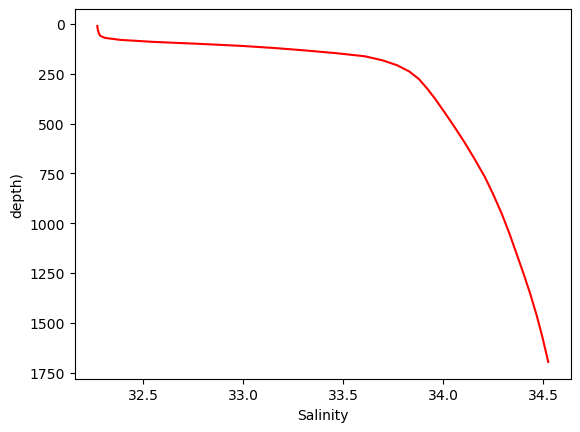

In [5]:

plt.plot(var_grid[1,:35,285,290], Z[:35], '-r')
plt.gca().invert_yaxis()
plt.xlabel("Salinity")
plt.ylabel("depth)")

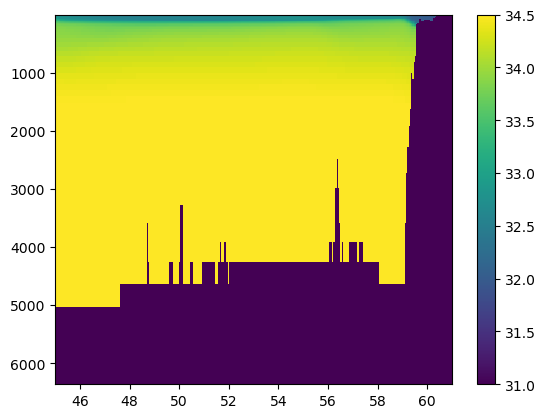

In [6]:
C = plt.pcolormesh(yc, Z[:50], var_grid[1, :50, :, 290], cmap='viridis', vmin=31,vmax=34.5) #variable, #depth, #lat, #lon
plt.gca().invert_yaxis()
plt.colorbar(C)
plt.show()

## Make a timeseries
After plotting a few fields, next we can see how the model is evolving through time. For this example, I'll choose a point in the domain near the coast and I'll plot that on a map to ensure it's in the right location:

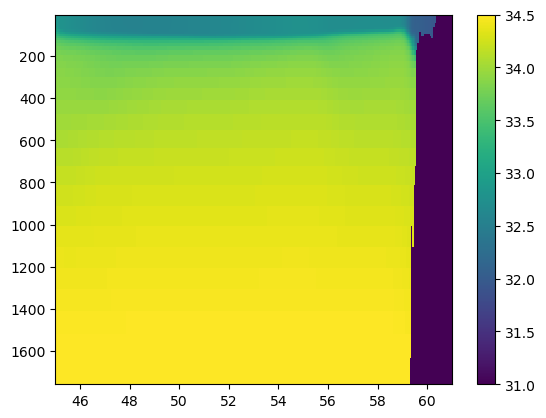

In [7]:
row = 285
col = 290
C = plt.pcolormesh(yc, Z[:35], var_grid[1, :35, :, 290], cmap='viridis', vmin=31,vmax=34.5)
plt.gca().invert_yaxis()
#plt.plot(col,row,'w.')
plt.colorbar(C)
plt.show()

When I'm happy with the location of the point, I'll loop through all of the output files to generate a timeseries:

In [8]:
timestep_numbers = []
salinity_values = []
for file_name in sorted(os.listdir(os.path.join(run_dir,'TS_3D_mon_mean'))):
    if file_name[-4:]=='data':
        # get the timestep number
        timestep_numbers.append(int(file_name.split('.')[-2]))
        grid = np.fromfile(os.path.join(run_dir,'TS_3D_mon_mean',
                                file_name), '>f4')
        grid = var_grid.reshape((2,Nr,n_rows,n_cols))
        salinity_values.append(grid[1,:50,row,col])
        

Finally, I'll plot the timeseries:

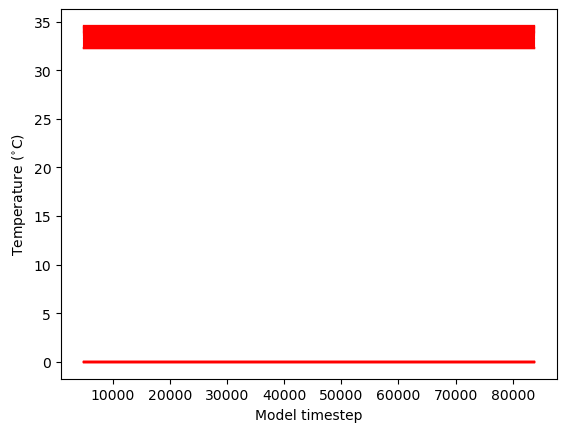

In [9]:
plt.plot(timestep_numbers, salinity_values,'r-')
plt.ylabel('Temperature ($^{\circ}$C)')
plt.xlabel('Model timestep')
plt.show()

## Make a movie
The timeseries looks pretty good - let's take a look at how our model is evolving through time by making a movie. First, let's make and test a function to make the panels for our movie

In [10]:
plot_dir = '/Users/kouryl/SJSU/CS185C/Project/figures'

In [11]:
def plot_panel(run_dir, plot_dir, file_name):

    # read in the data
    grid = np.fromfile(os.path.join(run_dir,'TS_3D_mon_mean',
                                file_name), '>f4')
    
    grid = grid.reshape((2,Nr,n_rows,n_cols))
    timestep_number = int(file_name.split('.')[-2])

    # make a figure 
    fig = plt.figure(figsize=(7,8))
    gs1 = GridSpec(11, 10, left=0.1, right=0.98, bottom=0.06, top=0.95, hspace=0.05)

    # plot the temperature
    ax1 = fig.add_subplot(gs1[:-2, :])
    C = ax1.pcolormesh(yc, Z[:35], var_grid[1, :35, :, 290], cmap='viridis', vmin=31,vmax=34.5)
    plt.gca().invert_yaxis()
    plt.colorbar(C, label='Salinity (PSU)')

    # # plot the land in grey
    # land = (grid[0,:,:-1]==0).astype(int)
    # print(np.min(land), np.max(land))
    # land = np.ma.masked_where(land, land==0)
    # print(land)
    # ax1.pcolormesh(XC[:,:-1], YC[:,:-1], land, cmap='Greys')#, vmin=-1, vmax=1)
    
    # format the axes
    plt.title(f'{file_name}')
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')

    max_timestep_number = int(366*24*60*60/300)
    ax2 = fig.add_subplot(gs1[-1, :-2])
    rect = Rectangle((0,0),timestep_number, 1, facecolor='grey', edgecolor='k')
    ax2.add_patch(rect)
    ax2.set_xlim([0, max_timestep_number])
    ax2.set_ylim([0, 1])
    ax2.set_xticks([0,max_timestep_number])
    ax2.set_xticklabels([2008,2009])
    ax2.set_yticklabels([])
    ax2.set_xlabel('Time')
    
    output_file = os.path.join(plot_dir,'panels',file_name[:-5]+'.png')
    plt.savefig(output_file, facecolor='white')
    plt.close(fig)


# test the function
plot_panel(run_dir, plot_dir, 'TS_3D_mon_mean.0000004896.data')
plot_panel(run_dir, plot_dir, 'TS_3D_mon_mean.0000048384.data')

When we're happy with the plotting function, we can use it to make the panels:

In [12]:
for file_name in sorted(os.listdir(os.path.join(run_dir,'TS_3D_mon_mean'))):
    if file_name[-4:]=='data':
        print(f'{file_name}')
        plot_panel(run_dir, plot_dir, file_name)

TS_3D_mon_mean.0000004896.data
TS_3D_mon_mean.0000013248.data
TS_3D_mon_mean.0000022176.data
TS_3D_mon_mean.0000030816.data
TS_3D_mon_mean.0000039744.data
TS_3D_mon_mean.0000048384.data
TS_3D_mon_mean.0000057312.data
TS_3D_mon_mean.0000066240.data
TS_3D_mon_mean.0000074880.data
TS_3D_mon_mean.0000083808.data


And then stitch everything together into a movie:

In [13]:
panel_list = []
for file_name in sorted(os.listdir(os.path.join(plot_dir,'panels'))):
    if file_name[-4:]=='.png':
        panel_list.append(os.path.join(plot_dir,'panels',file_name))

In [14]:
# set the frames per second
fps=5

# use the ImageSequenceClip module to set up the clip
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(panel_list, fps=fps)

# write the video to a file
clip.write_videofile(os.path.join(plot_dir,'Alaska Vertical Salinity(NEW).mp4'))

Moviepy - Building video /Users/kouryl/SJSU/CS185C/Project/figures/Alaska Vertical Salinity.mp4.
Moviepy - Writing video /Users/kouryl/SJSU/CS185C/Project/figures/Alaska Vertical Salinity.mp4



Moviepy - Done !
Moviepy - video ready /Users/kouryl/SJSU/CS185C/Project/figures/Alaska Vertical Salinity.mp4


This is just a first analysis with my first model run. Next, I will work to run my next model experiment and analyze the comparison.